# EXERCISE 9

## GENETIC ALGORITHMS PROBLEM

### Author: Vladislav Nikolov Vasilev

**Use a genetic algorithm to solve the example of page 84 with population size $M = 50$:**

$$ \max f(x,y) = 21.5 + x \sin(4\pi x) + y\sin(20\pi y) $$

**with**

$$(x, y) \in [-3.0, 12.11] \times [4.5, 5.8]$$


To solve this problem we have implemented a genetic algorithm that uses real-valued representation instead of the binary representation because it feels more natural to the given problem. This simplifies a lot the operations that have to be carried out and is more understandable and natural. However, there are some considerations that have to be taken into account.

To begin with, whenever a new chromosome is generated or mutated, we have to make sure that the chromosome is still a feasible solution to the problem. Therefore, we have implemented a method that makes sure that the genes of the chromosomes are still in the feasible region by clipping their values. This operation is applied after every crossover or mutation.

Secondly, we cannot use the same crossover as in the binary case because we cannot interchange as easily as before parts of two chromosomes. Instead, we are going to use the **BLX-$\alpha$** crossover. Given two chromosomes, $C_1 = (c_1^1, \dots, c_n^1)$ and $C_2 = (c_1^2, \dots, c_n^2)$, it generates two offsprings $O_1 = (o_1^1, \dots, o_n^1)$ and $O_2 = (o_1^2, \dots, o_n^2)$ where each $o_i^k$ is randomly (uniformly) chosen from the interval $[c_{min} - I\alpha, c_{max} + I\alpha]$, where $c_{max} = \max(c_i^1, c_i^2)$, $c_{min} = \min(c_i^1, c_i^2)$ and $I = c_{max} - c_{min}$. In other words, for each pair of genes of the parents we generate a new random uniform value in the interval between them and also in the extrema near them. This way, we can explore the surroundings of the current solutions by choosing values outside the extrema of the interval and we can exploit the better solutions by choosing values in the interval.

Finally, we cannot apply the same mutation as in the binary case. For real numbers, we can generate a random value from a normal distribution with mean $\mu$ and standard deviation $\sigma$ and add it to the selected gene.

Let's describe now how the algorithm works. We generate a population of size $M = 50$ and we evaluate them. To make things easier, we sort the population based on the corresponding fitness values from best to worst. Then we perform the optimization process. In each iteration, we select the chromosomes that will make it into the next generation. To do this, we select random pairs of chromosomes from the population, and for each one of them we perform a **binary tournament**, selecting the chromosome with the best fitness value. We repeat this process until we have a new population with $M$ chromosomes (they can be repeated).

Having selected the members of the new population, we perform the crossover. To do so, we generate $M$ random values from a $[0, 1)$ uniform distribution. Then we check the value of each random value. If it's smaller than the cross rate, then the corresponding chromosome is selected for mating. If we get an even number of chromosomes, we just remove the last one. We generate random couples and we apply the **BLX-$\alpha$** crossover.

After that, we try to mutate the new population. To do this, we generate a random value for each gene of each chromosome of the population. If it's smaller than the mutation rate then the previously defined mutation is applied to the gene. After we do that, we evaluate the new population and sort it according to its fitness values.

Finally, we compare the previous population with the new one and we apply an **elitism mnechanism**, which will allow us to keep the best solution found so far in the population. To implement, we compare the fitness values of the best chromosome from the previous generation with the best from the current. If the chromosome from the previous one is better, then we substitute the worst from the current and we sort again the population. Then, we repeat the process.

Let's see now an implementation of this algorithm:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GeneticAlgorithm:
    def __init__(self, pop_size, x_range, y_range, max_iter=10000, cross_rate=0.7, mutation_rate=0.001):
        self.pop_size = pop_size
        self.x_range = x_range
        self.y_range = y_range
        self.max_iter = max_iter
        self.cross_rate = cross_rate
        self.mutation_rate = mutation_rate
    
    
    def _initialize_population(self):
        '''
        Method to initialize a population of chromosomes
        '''
        population = np.random.uniform(size=(self.pop_size, 2))
        
        x_interval = self.x_range[1] - self.x_range[0]
        y_interval = self.y_range[1] - self.y_range[0]
        
        # Map [0, 1] values to corresponding ranges
        population[:, 0] = population[:, 0] * x_interval + self.x_range[0]
        population[:, 1] = population[:, 1] * y_interval + self.y_range[0]
        
        return population
    
    
    def _evaluate_population(self, population):
        '''
        Method to evaluate the population of chromosomes using the fitness function.
        '''
        x_values = population[:, 0]
        y_values = population[:, 1]
        
        return 21.5 + x_values * np.sin(4 * np.pi * x_values) + y_values * np.sin(20 * np.pi * y_values)
    
    
    def _sort_population_fitness(self, population, fitness):
        '''
        Method used to sort the population according to their fitness values.
        '''
        sort_idx = np.argsort(fitness)[::-1]
        
        return population[sort_idx], fitness[sort_idx]
    
    
    def _selection_schema(self, population, fitness):
        '''
        Method that implements the selection schema. It's based on the
        binary tournament, in which we select pairs of chromosomes that
        compete to see who has the best fitness value. The tournament is
        applied until we have a new population of the same size as the
        previous one.
        '''
        # The selection schema is based on the binary torunament
        new_population = []
        
        for _ in range(self.pop_size):
            idx_1, idx_2 = np.random.choice(self.pop_size, 2)
            new_population.append(population[idx_1] if fitness[idx_1] > fitness[idx_2] else population[idx_2])
        
        new_population = np.array(new_population)
        
        return new_population
    
    
    def _blx_alpha_crossover(self, parents, alpha=0.2):
        '''
        Method that implements the BLX-\alpha crossover operator. This
        is one of the crossover operators used for genetic algorithms
        that use the real-valued repesentation.
        '''
        # Compute min and max values column-wise
        c_min = np.min(parents, axis=0)
        c_max = np.max(parents, axis=0)

        # Compute interval
        i = c_max - c_min
        
        # Generate children
        child_1 = np.random.uniform(c_min - i * alpha, c_max + i * alpha)
        child_2 = np.random.uniform(c_min - i * alpha, c_max + i * alpha)
        
        children = np.vstack((child_1, child_2))
        children = self._clip_values(children)
        
        return children
        
    
    def _cross_schema(self, population):
        '''
        Method that implements the cross schema. For every chromosome
        in the population, a random number is generated and if it's below
        the threshold, the chromosome is selected for breeding. Then, random
        couples are formed and children are formed. These children replace
        their parents.
        '''
        prob_cross = np.random.uniform(size=self.pop_size)
        cross_idx = np.where(prob_cross < self.cross_rate)[0]
        
        # If length is even, remove last element
        if len(cross_idx) % 2 != 0:
            cross_idx = cross_idx[:-1]
        
        cross_idx = np.random.permutation(cross_idx)
        cross_idx = cross_idx.reshape(-1, 2)
        
        for couple_idx in cross_idx:
            parents = population[couple_idx]
            children = self._blx_alpha_crossover(parents)
            
            population[couple_idx] = children
            
        return population
    
    
    def _mutation(self, population, mean=0., sigma=0.7):
        '''
        Method that implements the mutation operator. It modifies a gene by
        adding a random value generated from a normal distribution with mean = 0
        and std=0.7.
        '''
        mutation_prob = np.random.uniform(size=population.shape)
        mutation_idx = np.where(mutation_prob < self.mutation_rate)
        
        population[mutation_idx] += np.random.normal(mean, sigma, size=mutation_idx[0].shape)
        population = self._clip_values(population)
        
        return population
    
    
    def _clip_values(self, population):
        '''
        Method used to make sure that the solutions to the problem are still
        feasible.
        '''
        population[:, 0] = np.clip(population[:, 0], *self.x_range)
        population[:, 1] = np.clip(population[:, 1], *self.y_range)
        
        return population
    
    
    def _elitism(self, old_population, old_fitness, new_population, new_fitness):
        '''
        Method used to keep the best solution until now. The worst one is
        discarded if the previous best solution has a better fitness
        value than the best solution of the current population.
        '''
        if old_fitness[0] > new_fitness[0]:
            new_population[-1] = old_population[0]
            new_fitness[-1] = old_fitness[0]
            
            new_population, new_fitness = self._sort_population_fitness(new_population, new_fitness)
        
        return new_population, new_fitness
    
        
    def train_predict(self, verbose=False):
        '''
        Method that trains a population of chromosomes a given number of iterations
        and returns the best solution.
        '''
        population = self._initialize_population()
        fitness = self._evaluate_population(population)
        
        # Sort population and fitness by fitness value
        population, fitness = self._sort_population_fitness(population, fitness)
        
        best_solutions = [fitness[0]]
        
        for i in range(self.max_iter):
            # 1. Selection
            new_population = self._selection_schema(population, fitness)
            new_fitness = self._evaluate_population(new_population)
            new_population, new_fitness = self._sort_population_fitness(new_population, new_fitness)
            
            # 2. Cross
            new_population = self._cross_schema(new_population)
            
            # 3. Mutate
            new_population = self._mutation(new_population)
            
            # 4. Evaluation and sorting
            new_fitness = self._evaluate_population(new_population)
            new_population, new_fitness = self._sort_population_fitness(new_population, new_fitness)
            population, fitness = self._elitism(population, fitness, new_population, new_fitness)
            
            best_solutions.append(fitness[0])
            
            if verbose and i % 1000 == 0:
                print(f'Iteration {i}/{self.max_iter}\tBest solution: {population[0]}\tFitness: {fitness[0]}')
        
        if verbose:
            print(f'Iteration {i+1}/{self.max_iter}\tBest solution: {population[0]}\tFitness: {fitness[0]}')
            
            plt.plot(np.arange(self.max_iter + 1), best_solutions)
            plt.xlabel('Number of iterations')
            plt.ylabel('Fitness value of the best value')
            
            plt.show()
        
        return population[0], fitness[0]

For this case, we have set cross_rate $ = 0.7$, mutation_rate $= 0.001$ and the stopping criterion as 10000 iterations. For the **BLX-$\alpha$** crossover we have used a value of $\alpha = 0.2$. For the mutation operator, we have set that $\mu = 0$ and $\sigma = 0.7$. With this in mind, let us now declare an instance of the class and run the algorithm.

In [3]:
pop_size = 50
x_range = (-3., 12.11)
y_range = (4.5, 5.8)

ga = GeneticAlgorithm(pop_size, x_range, y_range)

Iteration 0/10000	Best solution: [10.1663998   5.32876163]	Fitness: 35.5019752690798
Iteration 1000/10000	Best solution: [12.11        5.52504595]	Fitness: 38.920521529367356
Iteration 2000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 3000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 4000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 5000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 6000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 7000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 8000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 9000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683
Iteration 10000/10000	Best solution: [12.11        5.72504424]	Fitness: 39.12052072869683


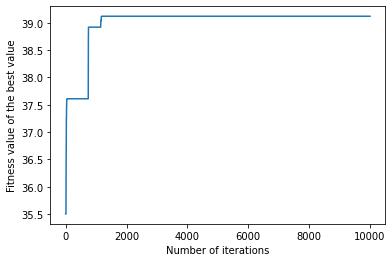

Found solution: [12.11        5.72504424]	Fitness value: 39.12052072869683


In [4]:
xy, fitness = ga.train_predict(verbose=True)

print(f'Found solution: {xy}\tFitness value: {fitness}')

As we can observe, we have reached a maximum at the ponts $x^* = 12.11$, $y^* = 5.72504424$, where the value of the function is $f(x^*, y^*) = 39.12052072869683$.

If we observe the graph, we can see how the the fitness value of the best chromosome of the population changes as the algorithm progresses. We see that it starts at around $35.5$ and it reaches the best value in less than 2000 iterations. After that, it doesn't improve. Thus, we could have defined some strategy to stop before.

Something that we should keep in mind is that the algorithm is indeed stochastic, which means that the best fitness values and how they evolve depend on the initial values (which are randomly generated). However, this technique is very powerful, because it can be used to optimize any kind of function without having any information of the function itself and its shapes. Also, it can be used to optimize non-continuos functions, which is a hughe advantage if we compare it to other methods.